<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/mhealth_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET"

COLS = ["ch_ax","ch_ay","ch_az","ecg1","ecg2",
        "ank_ax","ank_ay","ank_az","ank_gx","ank_gy","ank_gz",
        "ank_mx","ank_my","ank_mz",
        "arm_ax","arm_ay","arm_az","arm_gx","arm_gy","arm_gz",
        "arm_mx","arm_my","arm_mz",
        "label"]

dfs = []
for s in range(1, 11):
    fp = os.path.join(DATA_DIR, f"mHealth_subject{s}.log")
    df = pd.read_csv(fp, sep="\t", header=None, names=COLS, engine="python")
    df["subject"] = s
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

print("df_all:", df_all.shape)
print("라벨 분포:\n", df_all["label"].value_counts().sort_index())
print("\nsubject별 샘플 수:\n", df_all.groupby("subject").size())


df_all: (1215745, 25)
라벨 분포:
 label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: int64

subject별 샘플 수:
 subject
1     161280
2     130561
3     122112
4     116736
5     119808
6      98304
7     104448
8     129024
9     135168
10     98304
dtype: int64


In [ ]:
print(df_all.head())

    ch_ax     ch_ay    ch_az      ecg1      ecg2  ank_ax  ank_ay   ank_az  \
0 -9.8184  0.009971  0.29563  0.004186  0.004186  2.1849 -9.6967  0.63077   
1 -9.8489  0.524040  0.37348  0.004186  0.016745  2.3876 -9.5080  0.68389   
2 -9.6602  0.181850  0.43742  0.016745  0.037677  2.4086 -9.5674  0.68113   
3 -9.6507  0.214220  0.24033  0.079540  0.117220  2.1814 -9.4301  0.55031   
4 -9.7030  0.303890  0.31156  0.221870  0.205130  2.4173 -9.3889  0.71098   

     ank_gx   ank_gy  ...  arm_ay    arm_az   arm_gx  arm_gy    arm_gz  \
0  0.103900 -0.84053  ... -4.5781  0.187760 -0.44902 -1.0103  0.034483   
1  0.085343 -0.83865  ... -4.3198  0.023595 -0.44902 -1.0103  0.034483   
2  0.085343 -0.83865  ... -4.2772  0.275720 -0.44902 -1.0103  0.034483   
3  0.085343 -0.83865  ... -4.3163  0.367520 -0.45686 -1.0082  0.025862   
4  0.085343 -0.83865  ... -4.1459  0.407290 -0.45686 -1.0082  0.025862   

    arm_mx    arm_my    arm_mz  label  subject  
0 -2.35000 -1.610200 -0.030899      0      

In [ ]:
df_all

,ch_ax,ch_ay,ch_az,ecg1,ecg2,ank_ax,ank_ay,ank_az,ank_gx,ank_gy,...,arm_ay,arm_az,arm_gx,arm_gy,arm_gz,arm_mx,arm_my,arm_mz,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [ ]:
# 슬라이딩 윈도우 설정
FS=50; WIN=128; STEP=64
FEATS = [c for c in COLS if c!="label"]  # 특징 컬럼(=라벨 제외 모든 센서)

def make_windows(df):
    """창 내 최빈 라벨을 창 라벨로 사용"""
    X, y, subs = [], [], []
    sig = df[FEATS].to_numpy(dtype=np.float32)
    lab = df["label"].to_numpy(dtype=np.int16)
    sub = df["subject"].to_numpy(dtype=np.int16)
    for i in range(0, len(df)-WIN+1, STEP):
        j = i + WIN
        X.append(sig[i:j])
        y.append(np.bincount(lab[i:j]).argmax())
        subs.append(sub[i])
    return np.asarray(X), np.asarray(y), np.asarray(subs)

In [ ]:
# null 라벨(0) 제거 후 윈도잉
df_use = df_all[df_all["label"] != 0].reset_index(drop=True)
X_all, y_all_raw, subs_all = make_windows(df_use)

In [ ]:
# 라벨을 0~(C-1)로 인코딩
le = LabelEncoder()
y_all = le.fit_transform(y_all_raw)           # ex) 1~12 → 0~11
class_ids = list(range(len(le.classes_)))     # [0..C-1]
class_names = [str(c) for c in le.classes_]   # ['1','2',...,'12']
num_classes = len(class_ids)

print("윈도 라벨(원본):", np.unique(y_all_raw))
print("윈도 라벨(인코딩):", np.unique(y_all))
print("X_all:", X_all.shape, "classes:", num_classes)

윈도 라벨(원본): [ 1  2  3  4  5  6  7  8  9 10 11 12]
윈도 라벨(인코딩): [ 0  1  2  3  4  5  6  7  8  9 10 11]
X_all: (5361, 128, 23) classes: 12


In [ ]:
# 표준화 유틸
def fit_standardize(X_train):
    mu = X_train.mean(axis=(0,1), keepdims=True)
    sd = X_train.std(axis=(0,1), keepdims=True) + 1e-7
    return mu, sd
def apply_standardize(X, mu, sd):
    return (X - mu) / sd

In [ ]:
# 혼동행렬 그리기
def plot_confusion_matrix(cm, labels, title="Confusion Matrix", normalize=True):
    cm_disp = cm.astype(np.float32)
    if normalize:
        cm_disp = cm_disp / (cm_disp.sum(axis=1, keepdims=True) + 1e-9)
    plt.figure(figsize=(6,5))
    plt.imshow(cm_disp, interpolation='nearest')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels)
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout()

In [ ]:
# 5쌍 교차검증 페어 (테스트 2명씩)
PAIRS = [(1,2),(3,4),(5,6),(7,8),(9,10)]

In [ ]:
def build_lstm(input_shape, num_classes):
    inp = keras.Input(input_shape)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.LSTM(64)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out, name="LSTM")

input_shape = (WIN, len(FEATS))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.4293 - loss: 2.1286 - val_accuracy: 0.8029 - val_loss: 1.1559
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8244 - loss: 0.6859 - val_accuracy: 0.7902 - val_loss: 0.9583
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8728 - loss: 0.3627 - val_accuracy: 0.8481 - val_loss: 0.8614
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9556 - loss: 0.1889 - val_accuracy: 0.7486 - val_loss: 1.0942
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9526 - loss: 0.1794 - val_accuracy: 0.8553 - val_loss: 0.8936
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9737 - loss: 0.1241 - val_accuracy: 0.8734 - val_loss: 0.9398

[LSTM / Non-CV] macroF1: 0.7523512447022416
              precision    recall  f1-score   support

           1     0.9789    0.9688    0.9738        96
           2     0.0000    0.0000    0.0000        96
           3     1.0000    0.4

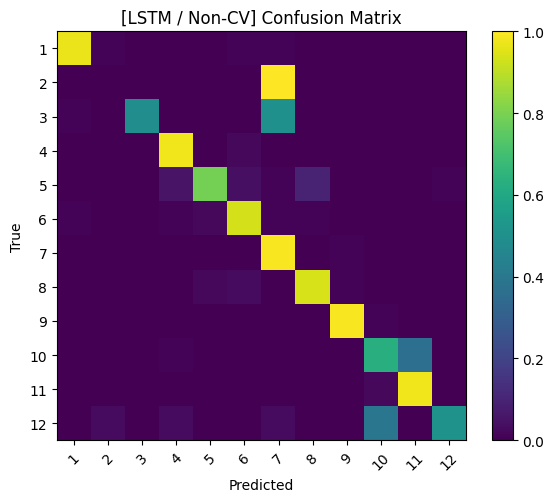

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# --------------------------
# Non-CV 데이터 분할 (subject-wise)
# --------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

# 그룹 = subs_all (피험자 번호)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=subs_all))

X_tr_full, X_te = X_all[train_idx], X_all[test_idx]
y_tr_full, y_te = y_all[train_idx], y_all[test_idx]
subs_tr_full = subs_all[train_idx]

# 학습/검증 분할도 그룹 기준으로 (검증 10%)
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
train_idx2, val_idx = next(gss_val.split(X_tr_full, y_tr_full, groups=subs_tr_full))

X_tr, X_va = X_tr_full[train_idx2], X_tr_full[val_idx]
y_tr, y_va = y_tr_full[train_idx2], y_tr_full[val_idx]

# --------------------------
# 표준화 (학습 기준)
# --------------------------
mu, sd = fit_standardize(X_tr)
X_tr = apply_standardize(X_tr, mu, sd)
X_va = apply_standardize(X_va, mu, sd)
X_te_s = apply_standardize(X_te, mu, sd)


lstm = build_lstm(input_shape, num_classes)
lstm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
lstm.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=20, batch_size=128, verbose=1, callbacks=[es])

y_pred = lstm.predict(X_te_s, verbose=0).argmax(axis=1)
print("\n[LSTM / Non-CV] macroF1:", f1_score(y_te, y_pred, average="macro", labels=class_ids))
print(classification_report(y_te, y_pred, digits=4, target_names=class_names))
cm = confusion_matrix(y_te, y_pred, labels=class_ids)
plot_confusion_matrix(cm, class_names, title="[LSTM / Non-CV] Confusion Matrix", normalize=True); plt.show()

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4012 - loss: 2.1047 - val_accuracy: 0.7864 - val_loss: 0.9069
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7958 - loss: 0.7149 - val_accuracy: 0.9343 - val_loss: 0.2564
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9230 - loss: 0.2588 - val_accuracy: 0.9765 - val_loss: 0.1353
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9416 - loss: 0.2156 - val_accuracy: 0.9624 - val_loss: 0.1460
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9543 - loss: 0.1568 - val_accuracy: 0.8685 - val_loss: 0.3871
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9410 - loss: 0.1844 - val_accuracy: 0.9789 - val_loss: 0.1112
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9855 - loss: 0.0783 - val_accuracy: 0.9812 - val_loss: 0.0827
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9591 - loss: 0.1596 - val_accuracy: 0.9413 - v

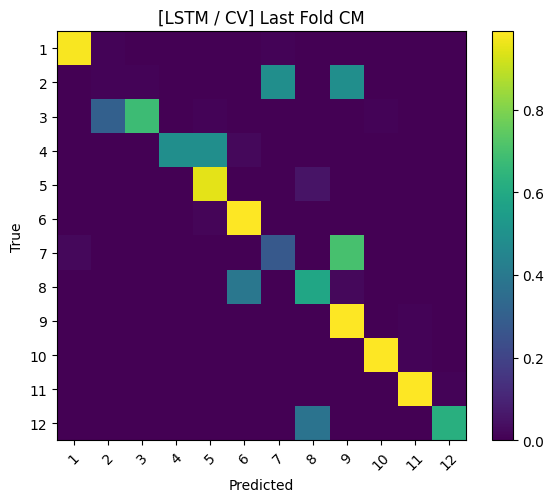

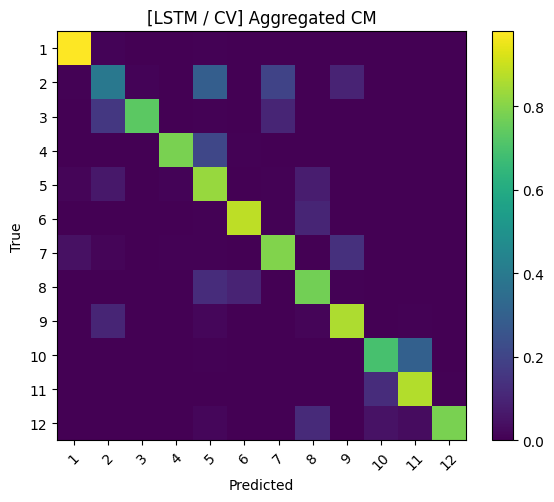

In [ ]:
f1_list = []
agg_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
last_cm = None

for pair in PAIRS:
    test_mask = np.isin(subs_all, pair)
    X_te, y_te = X_all[test_mask], y_all[test_mask]
    X_tr_full, y_tr_full = X_all[~test_mask], y_all[~test_mask]

    X_tr, X_va, y_tr, y_va = train_test_split(
        X_tr_full, y_tr_full, test_size=0.1, random_state=SEED, stratify=y_tr_full
    )

    mu, sd = fit_standardize(X_tr)
    X_tr = apply_standardize(X_tr, mu, sd)
    X_va = apply_standardize(X_va, mu, sd)
    X_te_s = apply_standardize(X_te, mu, sd)

    model = build_lstm(input_shape, num_classes)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=20, batch_size=128, verbose=1, callbacks=[es])

    y_pred = model.predict(X_te_s, verbose=0).argmax(axis=1)
    f1 = f1_score(y_te, y_pred, average="macro", labels=class_ids)
    f1_list.append(f1)
    print(f"[LSTM / CV][test {pair}] macroF1={f1:.4f}")

    cm = confusion_matrix(y_te, y_pred, labels=class_ids)
    agg_cm += cm
    last_cm = cm

print("\n[LSTM / CV] 5-fold macroF1 평균:", round(np.mean(f1_list),4), " | folds:", [round(x,4) for x in f1_list])
plot_confusion_matrix(last_cm, class_names, title="[LSTM / CV] Last Fold CM", normalize=True); plt.show()
plot_confusion_matrix(agg_cm, class_names, title="[LSTM / CV] Aggregated CM", normalize=True); plt.show()